In [1]:
import sys

from src.gauss_hist import get_gauss_stats

PWD = '../../..'
sys.path.append(PWD)

import numpy as np
import pandas as pd

import tensorflow as tf

tf.get_logger().setLevel('ERROR')
from tensorflow.keras import optimizers

from src.network_utils import count_params, plot_difference_hist
from src.cross_validator import CrossValidator
from src.dataset import load_dataset_train_test
from src.models import optimal_model_builders_ch_2_11 as optimal_model_builders

In [2]:
PROJECT_NAME = 'compare'

PLANE = 2
CHANNEL = 11

OVERWRITE = False

DATASET_PATH = PWD + '/data/dataset/dataset.pkl'
CROSSVAL_DIR = PWD + f'/data/model_selection/channel_{PLANE}_{CHANNEL}/cross_val'

LR = 0.01
ES_MIN_DELTA = 0.01

N_EPOCHS = 3000
BATCH_SIZE = 2048

CROSSVAL_N_CV = 5
CROSSVAL_N_EXEC = 3
LOSS_WEIGHT_REGULAR = 1000
LOSS_WEIGHT_HEATMAP = 10_000

In [3]:
X_base_train, _, y_base_train, _ = load_dataset_train_test(PWD, PLANE, CHANNEL)

X_base_train.shape

(22412, 24)

In [4]:
def gaussian_kernel(mu, sigma=1., n=24):
    x = np.arange(0, n)
    return np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))


y_base_train_heatmap = np.array([gaussian_kernel(y) for y in y_base_train])

y_base_train_heatmap.shape

(22412, 24)

In [5]:
def compile_wrapper(builder, loss_weight):
    def compiled_builder():
        model = builder()
        model.compile(loss='mse', optimizer=optimizers.Adam(LR), loss_weights=loss_weight)
        return model

    return compiled_builder

# Regular models

Number of parameters: 457
Got score: 85.2190 (85.5451, 85.2868, 84.8253)
Got score: 84.6746 (84.0691, 85.1681, 84.7866)
Got score: 82.2003 (82.1056, 82.1851, 82.3101)
Got score: 83.7553 (83.5542, 83.8992, 83.8125)
Got score: 85.5404 (85.9543, 85.4865, 85.1803)


Number of parameters: 16369
Got score: 84.9611 (85.1929, 84.9373, 84.7530)
Got score: 83.7266 (84.1434, 83.5934, 83.4430)
Got score: 81.7129 (81.5189, 81.7619, 81.8579)
Got score: 83.4113 (83.3518, 83.0829, 83.7992)
Got score: 85.2117 (85.6811, 85.0960, 84.8578)


Number of parameters: 50435
Got score: 85.1296 (84.8882, 85.4136, 85.0869)
Got score: 83.9341 (84.0275, 84.0479, 83.7271)
Got score: 81.5496 (81.2884, 81.9310, 81.4293)
Got score: 83.6076 (83.5297, 83.5961, 83.6969)
Got score: 85.5748 (85.4440, 85.7989, 85.4815)


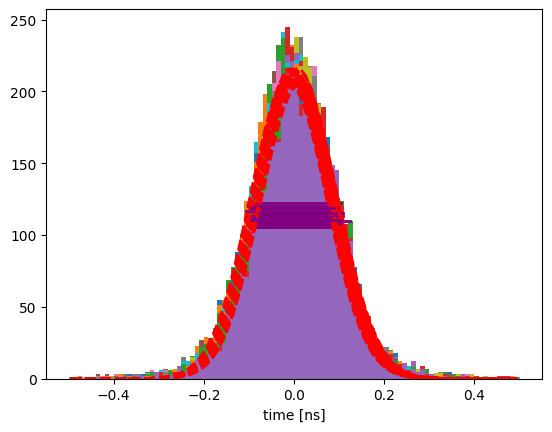

In [6]:
def regular_metric(y_true, y_pred):
    std, _, _ = plot_difference_hist(y_true, y_pred[:, 0], show=False, close=False)
    return std * 1000  # ps


regular_model_builders = [
    compile_wrapper(optimal_model_builders.mlp, loss_weight=LOSS_WEIGHT_REGULAR),
    compile_wrapper(optimal_model_builders.convnet, loss_weight=LOSS_WEIGHT_REGULAR),
    compile_wrapper(optimal_model_builders.rnn, loss_weight=LOSS_WEIGHT_REGULAR),
]
regular_model_names = ['mlp', 'convnet', 'rnn']

cross_validator = CrossValidator(regular_model_builders, X_base_train, y_base_train, CROSSVAL_DIR, PROJECT_NAME,
                                 n_epochs=N_EPOCHS, batch_size=BATCH_SIZE, es_min_delta=ES_MIN_DELTA,
                                 n_cv=CROSSVAL_N_CV, n_executions=CROSSVAL_N_EXEC, model_names=regular_model_names,
                                 eval_metric=regular_metric, overwrite=OVERWRITE)

regular_model_scores = cross_validator()

# Heatmap-based models

Number of parameters: 367043


C:\Users\MatiX\miniconda3\envs\cern-ml\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


Got score: 87.7962 (92.9121, 85.0672, 85.4092)
Got score: 84.5298 (84.3610, 84.7182, 84.5102)
Got score: 81.9663 (82.3312, 81.8575, 81.7103)
Got score: 84.0150 (84.3513, 83.7995, 83.8943)
Got score: 85.7427 (85.8715, 85.7360, 85.6206)


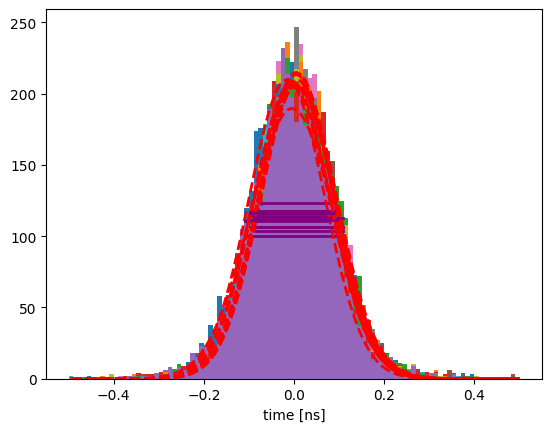

In [7]:
def heatmap_metric(y_heatmap_true, y_heatmap_pred):
    x = np.arange(24)

    y_true = np.empty(y_heatmap_true.shape[0])
    for i, y in enumerate(y_heatmap_true):
        _, y_true[i], _, _ = get_gauss_stats(x, y, a_0=1, std_0=1.)

    y_pred = np.empty(y_heatmap_pred.shape[0])
    for i, y in enumerate(y_heatmap_pred):
        _, y_pred[i], _, _ = get_gauss_stats(x, y, a_0=1, std_0=1.)

    std, _, _ = plot_difference_hist(y_true, y_pred, show=False, close=False)
    return std * 1000  # ps


heatmap_model_builders = [compile_wrapper(optimal_model_builders.unet, loss_weight=LOSS_WEIGHT_HEATMAP)]
heatmap_model_names = ['unet']

cross_validator = CrossValidator(heatmap_model_builders, X_base_train, y_base_train_heatmap, CROSSVAL_DIR, PROJECT_NAME,
                                 n_epochs=N_EPOCHS, batch_size=BATCH_SIZE, es_min_delta=ES_MIN_DELTA,
                                 n_cv=CROSSVAL_N_CV, n_executions=CROSSVAL_N_EXEC, model_names=heatmap_model_names,
                                 eval_metric=heatmap_metric, overwrite=OVERWRITE)

heatmap_model_scores = cross_validator()

# Comparison

In [8]:
all_model_builders = regular_model_builders + heatmap_model_builders
all_model_names = regular_model_names + heatmap_model_names
all_model_scores = regular_model_scores | heatmap_model_scores

In [9]:
mean_scores = [f"{np.mean(scores):0.2f}" for scores in all_model_scores.values()]
std_scores = [f"{np.std(scores):0.2f}" for scores in all_model_scores.values()]
n_params = [count_params(builder()) for builder in all_model_builders]

df = pd.DataFrame({'mean': mean_scores, 'std': std_scores, 'n_params': n_params}, index=all_model_scores.keys())
df.index.name = 'Model'
df

,mean,std,n_params
Model,,,
mlp,84.28,1.20,457
convnet,83.80,1.25,16369
rnn,83.96,1.41,50435
unet,84.81,1.93,367043
